# OntoWeaver Vignette
OntoWeaver is a tool for constructing Semantic Knowledge Graphs (SKG) from iterative data, such as CSV files. It allows users to define mappings between the data and an ontology, enabling the creation of a graph that can be queried and analyzed. This notebook provides a step-by-step guide on how to use OntoWeaver, on top of BioCypher, to build an SKG from clinical and genomic data, aimed to be used for personalized medicine.

## Background

We define personalized medicine as the targeted inhibition of driver events, with some of its main goals being:
- the targeted inhibition of driver events,
- understanding the biological mechanisms thereof, and
- the identification of treatments and their underlying mechanisms.

Imagine you are a geneticist and are studying alterations in ovarian cancer, with an aim to find the best treatment for a given patient. Let's assume that the patient has the following alteration: brca1:chr17:43094490:CA:C, in the BRCA1 gene.

In order to find the appropriate treatment, you would currently have to conduct a manual search through existing databases, and recover information about the affected gene, possible currently available treatments, and the biological pathways these treatments are targeting.

In practice, this would require:

- identifying the role of the affected gene, for example through the exploration of databases such as [gene cards](https://www.genecards.org/cgi-bin/carddisp.pl?gene=BRCA1), which provides information about annotated genes,
- exploring available treatments by using, for example, the [OncoKB database](https://www.oncokb.org/gene/BRCA1),
- and finally identifying the underlying mechanisms of these treatments, through databases such as [Open Targets](https://platform.opentargets.org/drug/CHEMBL521686).

Seeing that a single patient can have a number of alterations affecting different regions, this can elongate the process of database exploration.

Our approach, therefore, combines different databases into a single Semantic Knowledge Graph.

## Semantic Knowledge Graphs

In order to map our data into a semantic knowledge graph we use ontologies. An ontology is a set of entities (classes), which are organized in a hierarchical structure from general concepts to more specific ones. On the figure below we show a sample of the Biolink ontology with the most general term ``entity`` branching into classes ``association`` and ``named thing``, which further branch into subclasses.

```
entity
  │
  ├─ association
  │    ├─ patient has variant
  │    ├─ variant to gene association
  │    └─ treatment has citation
  │
  └─ named thing
       ├─ patient - case
       ├─ gene
       └─ disease
```

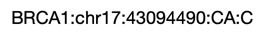
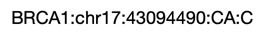
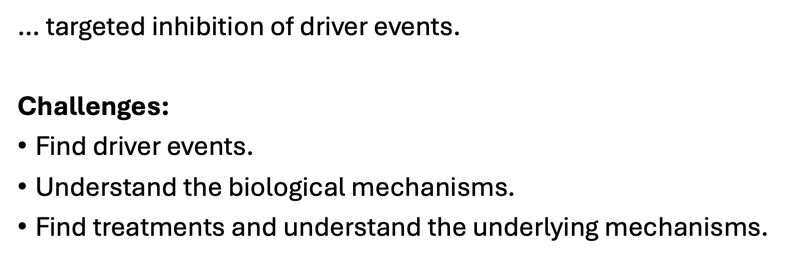
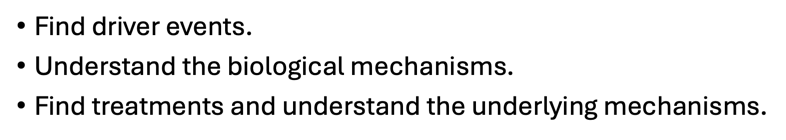

Let's look at an example of what a semantic knowledge graph mapped onto an ontology would look like:

```
Thing
  │
  ├─ Association
  │    └─  genotype to phenotypic feature
  │             └─ reference genome
  │
  └─ Entity
       ├─ sequence variant
       └─ genome
```

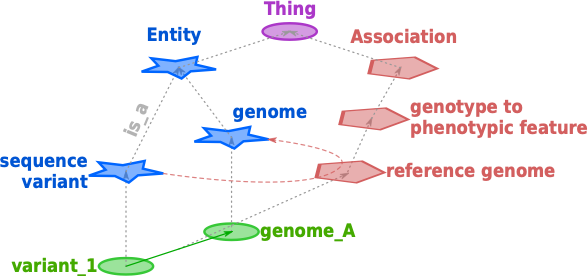

In [5]:
from IPython.display import Image

display(Image("figures/jobim/kg_schema.png"))

We show here a knowledge graph representing the ontology above, starting from the most general term of the ontology ``Thing``, branching into ``Entity`` and ``Association`` classes, which further branch into ``Genome`` and ``Sequence variant`` subclasses on the ``Entity`` side, and ``genotype to phenotypic feature`` and ``reference genome`` subclasses on the ``Association`` side.

On the lower side of the figure we see a simple knowledge graph with two nodes:
- ``variant_1`` which represents an instance of a ``sequence variant``, and
- ``genome_A`` which represents an instance of a ``genome``

These nodes are connected via an edge of type ``reference genome``, thus preserving the ontological structure of the data.

## Description of the data

In this tutorial, we are building a SKG from different sources:
- **Single Nucleotide Variants (SNVs)**: A data table containing information about single nucleotide variants found in ovarian cancer patients.
- **Copy Number Alterations (CNAs)**: A data table containing information about copy number alterations found in ovarian cancer patients.
- **Treatments (OncoKB)**: A [public database](https://www.oncokb.org/) that contains biological and clinical information about genomic alterations in cancer.
-
The examples in this vignette are based on anonymized, shuffled and subsetted data from real databases, with the alterations of patients replaced by numbers 1 to 10 followed by the type of alteration (SNV or CNA).

### Details of the databases:
#### Single Nucleotide Variants (SNVs)
Columns:
- patient_id: Id of the patient.
- sample_id: Id of the sample.
- hugoSymbol: Gene Symbol.
- alteration: Mutation in the DNA sequence in the format: HugoSymbol:chr:DNA_sequences_changes.
- outcome: Gene outcome. Example: Gain-of-function, Loss-of-function.

### Copy Number Alterations (CNAs)
Columns:
- patient_id: Id of the patient.
- sample_id: Id of the sample.
- hugoSymbol: Gene Symbol.
- alteration: AMPLIFICATION or DELETION.
- variantSummary: Description of the alteration.
- tumorTypeSummary: Summary of knowledge about this mutation.

### Treatments (OncoKB)
Columns:
- alteration: Mutation in the DNA sequence in the format HugoSymbol:chr:DNA_sequences_changes for single nucleotide variants and HugoSymbol:AMPLIFICATION|DELETION for copy number alterations.
- treatment: Name of the drug.

## Set-up

### Installing dependencies

We use *Poetry* to manage dependencies and virtual environments. If you don't have it installed, you can install it with:

In [4]:
! poetry install --no-root

Installing dependencies from lock file

No dependencies to install or update


So far, the OntoWeaver package works under python 3.12. If you have multiple python versions installed, you can direct *Poetry* to use the correct one with the following command:
`! poetry env use $(which python3.12)`

### Starting the *poetry* environment

In [5]:
! eval $(poetry env activate) # new implementation of `poetry shell`

## SKG construction

### 1. Simple mapping using SNVs

First, let's look at the available data we have from the Single Nucleotide Variants database.

In [3]:
import pandas as pd

df = pd.read_csv("data/jobim_subsets/1_Simple_mapping/snv_subset_1.csv")

df

,patient_id,sample_id,hugoSymbol,alteration
0,CC1343,CC5333_p2OvaL1_DNA1,LATS1,1_snv
1,EX1,EX1_pOvaL1_DNA1,BRCA1,2_snv
2,CC3540,CC2207_pPer1_DNA1,ARID1B,3_snv
3,CC4898,CC0638_iOme_DNA1,TP53,4_snv
4,CC2114,CC0047_iBow1_DNA1,TP53,5_snv
5,CC4700,CC1860_pOvaR1_TR,ARID2,6_snv
6,CC4804,CC3307_pAdnL1_DNA3,TBL2,7_snv
7,CC9548,CC9256_pPer_DNA4,TP53,8_snv
8,CC7699,CC8958_pOva_DNA1,TP53,9_snv
9,CC2375,CC1492_iOth1_DNA1,ADAM12,10_snv


We want to build a KG with a simple schema, encompassing patient IDs, the IDs of the samples they provided, the sequence variants they have, and the genes those variants are in. We first start by defining the schema of the desired graph, which would in our case look like this:

In [5]:
from IPython.display import SVG, display
display(SVG("figures/jobim/Example_graph_1.svg"))

After defining the schema, we need to define the mappings between the data and the ontology. The mappings will specify how each column in the CSV files corresponds to a node or edge in the graph. This is defined in the OntoWeaver mapping files, which are YAML files that describe the structure of the data and how it should be transformed into nodes and edges in the graph.

Below we display the mapping file we use for the build up of the first example graph of the SNV database.

In [4]:
import yaml
from IPython.display import display, JSON

# Read the file content.
with open("jobim/1_Simple_mapping/snv.yaml", "r") as file:
    content = yaml.safe_load(file)

# Display the content.
display(JSON(content))

<IPython.core.display.JSON object>

OntoWeaver maps the databases row by row, so the mapping file first specifies how the subject node of each row mapped will be created. We first define that the subject ID will be created from the `patient_id`, using the `columns` keyword, and that the node will be of type `patient`, using the `to_subject` keyword.

For each column we want to map, we must define the strategy of the extraction of the values from each cell of the column, which will serve as the ID of the created node. For this, we use `transformers`. OntoWeaver provides a robust set of transformers that can be used to extract and transform data from the columns of the CSV files. These transformers can be used to manipulate the data in various ways, such as combining several column values, splitting concatenated values, and many more. Detailed description of the transformers can be found in the [OntoWeaver documentation](https://ontoweaver.readthedocs.io/en/latest/readme_sections/mapping_api.html#available-transformers). Users are also able to program their own transformers to suit their specific needs.

For simplicity, in this first section we keep to the usage of only the `map` transformer, which simply extracts the data as it is from the cells of the defined column. For each transformer we define the `columns` to use for the extraction of the data, as well as the `to_object` keyword, which defines the type of node to be created from the extracted data, such as `gene` or `sample`. In addition to that, we also define the edge which is connecting the created nodes to the subject node, using the `via_relation` keyword.

In some cases we do not want to use the default subject type for each row, but rather use a different column as the start point of an edge. In this case, we can use the `from_subject` keyword to specify the type from which we want the edge to start from. For example, in the mapping file above, we use the `from_subject` keyword to create an edge type `alteration_affects_gene` from the `alteration` node, to the `gene` node, thus voiding the start of the edge from the `patient` node. which is the default subject type for each row.

After having identified the general structure of the graph and the definition of the mappings, we must now define the BioCypher schema, which is a YAML file that describes the structure of the graph. The schema defines the nodes and edges in the graph, their properties, and how they are related to each other. You can find more information about the BioCypher schema in the [BioCypher documentation](https://biocypher.org/BioCypher/learn/tutorials/pandas_tutorial/#schema-configuration).

In [5]:
import yaml
from IPython.display import display, JSON

# Read the file content.
with open("jobim/1_Simple_mapping/biocypher_schema.yaml", "r") as file:
    content = yaml.safe_load(file)

# Display the content.
display(JSON(content))

<IPython.core.display.JSON object>

Below we show the OntoWeaver CLI command, which is used to run the mapping process. The command specifies the input CSV file, the mapping file, the Biocypher configuration file, and the Biocypher schema file. The `--biocypher-config` option points to a YAML file that contains the configuration for Biocypher, while the `--biocypher-schema` option points to a YAML file that defines the schema of the graph.

More information about the OntoWeaver CLI can be found by running:

In [8]:
! poetry run ontoweave --help

INFO -- This is BioCypher v0.12.2.
INFO -- Logging into `biocypher-log/biocypher-20260115-105439.log`.
/Users/mbaric/Library/Caches/pypoetry/virtualenvs/ontoweaver-vignette-Q0c7RTWb-py3.12/lib/python3.12/site-packages/rdflib/extras/external_graph_libs.py:80: SyntaxWarning: invalid escape sequence '\*'
  """Converts the given graph into a networkx.MultiDiGraph.
/Users/mbaric/Library/Caches/pypoetry/virtualenvs/ontoweaver-vignette-Q0c7RTWb-py3.12/lib/python3.12/site-packages/rdflib/extras/external_graph_libs.py:137: SyntaxWarning: invalid escape sequence '\*'
  """Converts the given graph into a networkx.DiGraph.
/Users/mbaric/Library/Caches/pypoetry/virtualenvs/ontoweaver-vignette-Q0c7RTWb-py3.12/lib/python3.12/site-packages/rdflib/extras/external_graph_libs.py:200: SyntaxWarning: invalid escape sequence '\*'
  """Converts the given graph into a networkx.Graph.
usage: ontoweave [-h] [-c FILE] [--print_config[=flags]] [-C FILE] [-s FILE]
                 [-p NB_CORES] [-i] [-R KEY] [-r [

Below we show the command that we use to run the mapping process for the first example graph of the SNV database. The command specifies the input CSV file, the mapping file, the Biocypher configuration file, and the Biocypher schema file. The `-a suffix` option is used to add a suffix to the generated nodes. Each suffix represents the ontological type of the node.

In [9]:
! poetry run ontoweave ./data/jobim_subsets/1_Simple_mapping/snv_subset_1.csv:./jobim/1_Simple_mapping/snv.yaml --biocypher-config ./jobim/1_Simple_mapping/biocypher_config.yaml --biocypher-schema ./jobim/1_Simple_mapping/biocypher_schema.yaml -a suffix

INFO -- This is BioCypher v0.12.2.
INFO -- Logging into `biocypher-log/biocypher-20260115-105453.log`.
/Users/mbaric/ontoweaver-vignette/biocypher-out/20260115105456/neo4j-admin-import-call.sh


In addition to the `ontoweave` CLI, you can also write a short script using the available extraction functions to achieve the same result.

In [15]:
import biocypher
import ontoweaver

# Define the path to the mapping file.
data_mapping = {f"./data/jobim_subsets/1_Simple_mapping/snv_subset_1.csv": f"./jobim/1_Simple_mapping/snv.yaml"}

# Extract nodes and edges from the mapping file.
nodes, edges = ontoweaver.extract(data_mapping, affix = "suffix")

# Transform nodes and edges to correct format.
nodes = ontoweaver.ow2bc(nodes)
edges = ontoweaver.ow2bc(edges)

# Write the nodes and edges using BioCypher.
bc = biocypher.BioCypher(
    biocypher_config_path=f"./jobim/1_Simple_mapping/biocypher_config.yaml",
    schema_config_path=f"./jobim/1_Simple_mapping/biocypher_schema.yaml",
)

bc.write_nodes(nodes)
bc.write_edges(edges)
bc.write_import_call()


INFO -- Running BioCypher with schema configuration from ./jobim/1_Simple_mapping/biocypher_schema.yaml.
INFO:biocypher:Running BioCypher with schema configuration from ./jobim/1_Simple_mapping/biocypher_schema.yaml.
INFO -- Loading ontologies...
INFO:biocypher:Loading ontologies...
INFO -- Instantiating OntologyAdapter class for https://github.com/biolink/biolink-model/raw/v3.2.1/biolink-model.owl.ttl.
INFO:biocypher:Instantiating OntologyAdapter class for https://github.com/biolink/biolink-model/raw/v3.2.1/biolink-model.owl.ttl.
INFO -- Instantiating OntologyAdapter class for http://purl.obolibrary.org/obo/so.owl.
INFO:biocypher:Instantiating OntologyAdapter class for http://purl.obolibrary.org/obo/so.owl.
INFO -- Instantiating OntologyAdapter class for http://purl.obolibrary.org/obo/so.owl.
INFO:biocypher:Instantiating OntologyAdapter class for http://purl.obolibrary.org/obo/so.owl.
INFO -- Creating output directory `/Users/mbaric/ontoweaver-vignette/biocypher-out/20260115134426`.
I

'/Users/mbaric/ontoweaver-vignette/biocypher-out/20260115134426/neo4j-admin-import-call.sh'

The generated graph is visualized in Neo4j, and looks like this:

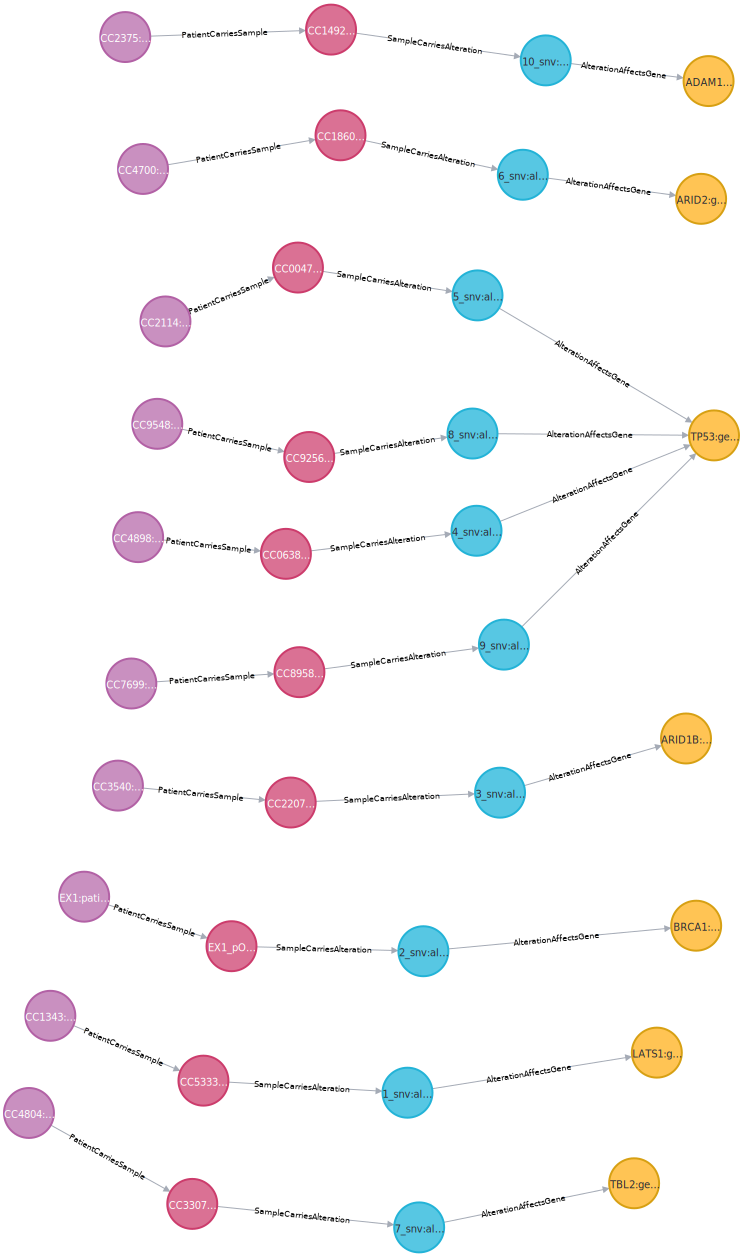

In [32]:
display(SVG("figures/jobim/graph_1.svg"))

## 2. Adding properties and metadata

It is often useful to attach additional metadata to the nodes and edges in the graph. This metadata can include information such as the source of the data, the date of creation, or any other relevant information that can help in understanding the context of the data. This metadata is attached via the usage of properties.

Let's look at an extended version of the database we used in the previous section:

In [33]:
df = pd.read_csv("data/jobim_subsets/2_Properties/snv_subset_2.csv")
df

,patient_id,sample_id,hugoSymbol,alteration,mutationEffectDescription
0,CC1343,CC5333_p2OvaL1_DNA1,LATS1,1_snv,The mutation effect description for truncating...
1,EX1,EX1_pOvaL1_DNA1,BRCA1,2_snv,The mutation effect description for truncating...
2,CC3540,CC2207_pPer1_DNA1,ARID1B,3_snv,The mutation effect description for truncating...
3,CC4898,CC0638_iOme_DNA1,TP53,4_snv,The mutation effect description for truncating...
4,CC2114,CC0047_iBow1_DNA1,TP53,5_snv,The mutation effect description for truncating...
5,CC4700,CC1860_pOvaR1_TR,ARID2,6_snv,The mutation effect description for truncating...
6,CC4804,CC3307_pAdnL1_DNA3,TBL2,7_snv,NaN
7,CC9548,CC9256_pPer_DNA4,TP53,8_snv,The mutation effect description for truncating...
8,CC7699,CC8958_pOva_DNA1,TP53,9_snv,The mutation effect description for truncating...
9,CC2375,CC1492_iOth1_DNA1,ADAM12,10_snv,NaN



We have an additional column called `mutationEffectDescription`, which contains a description of the effect of a given alteration. We can use this column to add a property to the `alteration` nodes in the graph. Our extended graph schema would look like this:



In [18]:
display(SVG("figures/jobim/Example_2_properties.svg"))


The property will be created by using the `map` transformer, which will extract the data from the `mutationEffectDescription` column and attach it to the `alteration` nodes. We achieve this by adding a `to_property` keyword to the mapping file, which specifies the name of the property to be created, as well as the `for_objects` keyword, which specifies the type of node or edge to which the property will be attached. In this case, we want to attach the property to the `alteration` nodes.

In [34]:
# Read the file content.
with open("jobim/2_Properties/snv.yaml", "r") as file:
    content = yaml.safe_load(file)

# Display the content.
display(JSON(content))

<IPython.core.display.JSON object>

In addition to defining the correct properties in the mapping file, we also need to define the properties in the BioCypher schema. The schema defines the properties that can be attached to the nodes and edges in the graph, as well as their data types. In this case, we want to add a property called `mutationEffectDescription` to the `alteration` nodes, which will be of type `string`. We achieve this by adding a `properties` section to the schema file, which specifies the name of the property and its data type.

Let's look at the updated mapping file:

In [23]:
# Read the file content.
with open("jobim/2_Properties/biocypher_schema.yaml", "r") as file:
    content = yaml.safe_load(file)

# Display the content.
display(JSON(content))

<IPython.core.display.JSON object>

We run the `ontoweave` CLI once again, as well as the code alternative.

In [16]:
! poetry run ontoweave ./data/jobim_subsets/2_Properties/snv_subset_2.csv:./jobim/2_Properties/snv.yaml --biocypher-config ./jobim/2_Properties/biocypher_config.yaml --biocypher-schema ./jobim/2_Properties/biocypher_schema.yaml -a suffix


INFO -- This is BioCypher v0.12.2.
INFO -- Logging into `biocypher-log/biocypher-20260115-134437.log`.
/Users/mbaric/ontoweaver-vignette/biocypher-out/20260115134440/neo4j-admin-import-call.sh


In [17]:
import biocypher
import ontoweaver

# Define the path to the mapping file.
data_mapping = {f"./data/jobim_subsets/2_Properties/snv_subset_2.csv": f"./jobim/2_Properties/snv.yaml"}

# Extract nodes and edges from the mapping file.
nodes, edges = ontoweaver.extract(data_mapping, affix = "suffix")

# Transform nodes and edges to correct format.
nodes = ontoweaver.ow2bc(nodes)
edges = ontoweaver.ow2bc(edges)

# Write the nodes and edges using BioCypher.
bc = biocypher.BioCypher(
    biocypher_config_path=f"./jobim/2_Properties/biocypher_config.yaml",
    schema_config_path=f"./jobim/2_Properties/biocypher_schema.yaml",
)

bc.write_nodes(nodes)
bc.write_edges(edges)
bc.write_import_call()

INFO -- Running BioCypher with schema configuration from ./jobim/2_Properties/biocypher_schema.yaml.
INFO:biocypher:Running BioCypher with schema configuration from ./jobim/2_Properties/biocypher_schema.yaml.
INFO -- Loading ontologies...
INFO:biocypher:Loading ontologies...
INFO -- Instantiating OntologyAdapter class for https://github.com/biolink/biolink-model/raw/v3.2.1/biolink-model.owl.ttl.
INFO:biocypher:Instantiating OntologyAdapter class for https://github.com/biolink/biolink-model/raw/v3.2.1/biolink-model.owl.ttl.
INFO -- Instantiating OntologyAdapter class for http://purl.obolibrary.org/obo/so.owl.
INFO:biocypher:Instantiating OntologyAdapter class for http://purl.obolibrary.org/obo/so.owl.
INFO -- Instantiating OntologyAdapter class for http://purl.obolibrary.org/obo/so.owl.
INFO:biocypher:Instantiating OntologyAdapter class for http://purl.obolibrary.org/obo/so.owl.
INFO -- Creating output directory `/Users/mbaric/ontoweaver-vignette/biocypher-out/20260115134446`.
INFO:bioc

'/Users/mbaric/ontoweaver-vignette/biocypher-out/20260115134446/neo4j-admin-import-call.sh'

Now, each alteration node has the new property attached to itself. This can be easily visualized in the Neo4j browser.

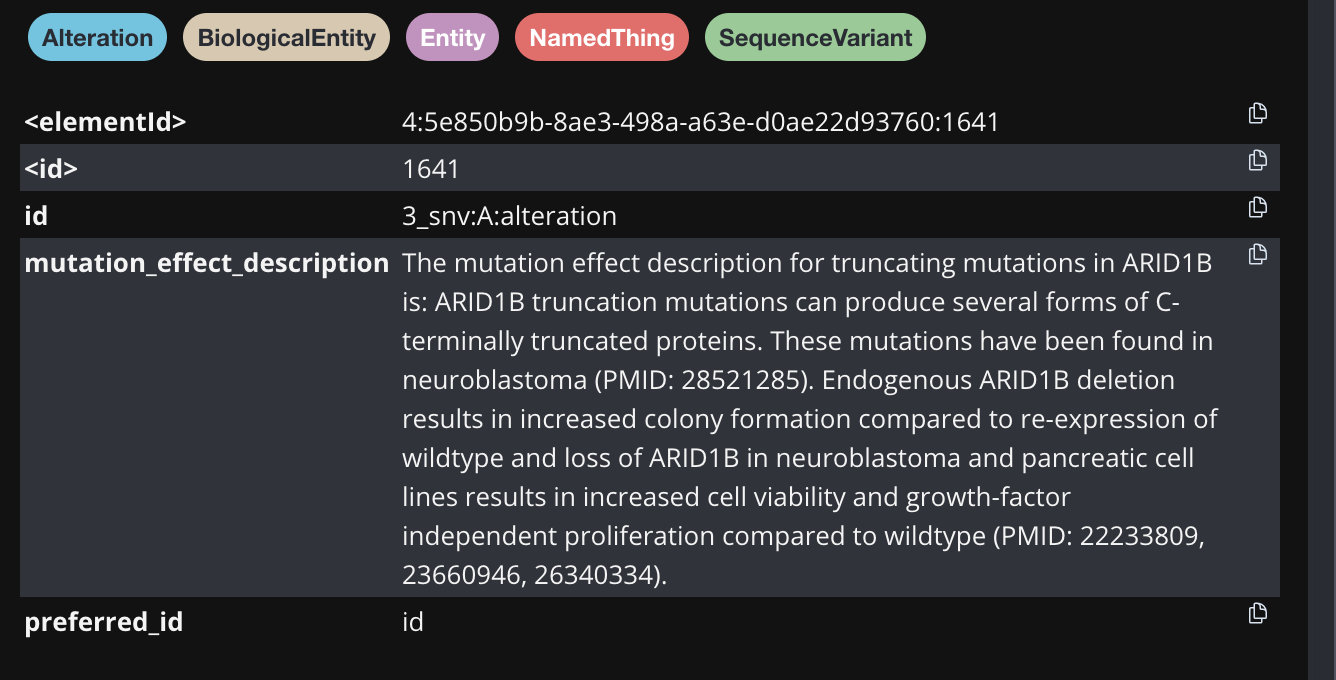

In [29]:
from IPython.display import display, JSON, Image

display(Image("figures/jobim/Node_properties.png"))

In some cases you may wish to add metadata to all the nodes and edges you extract from a single database, such as the database name, origin, etc. Imagine that we want to add a property called `name` to all the nodes and edges extracted from the SNV database, which will contain the name of the database. Our graph schema would look like this:


In [24]:
display(SVG("figures/jobim/Example_2_metadata.svg"))

This can be easily achieved by using the `metadata` option OntoWeaver provides. The metadata is defined in the mapping file, and it will be added to all the nodes and edges extracted from the database. Below we show an example of how to define the metadata in the mapping file.

In [34]:
# Read the file content.
with open("jobim/2_Properties/snv_metadata.yaml", "r") as file:
    content = yaml.safe_load(file)

# Display the content.
display(JSON(content))

<IPython.core.display.JSON object>

This new change must also be reflected in the BioCypher schema, so we need to update the schema file to include an additional property called `name`.

In [35]:
# Read the file content.
with open("jobim/2_Properties/biocypher_schema_metadata.yaml", "r") as file:
    content = yaml.safe_load(file)

# Display the content.
display(JSON(content))

<IPython.core.display.JSON object>

As in the previous section, we can run the OntoWeaver CLI to map the data from the CSV file to the graph.

In [18]:
! poetry run ontoweave ./data/jobim_subsets/2_Properties/snv_subset_2.csv:./jobim/2_Properties/snv_metadata.yaml --biocypher-config ./jobim/2_Properties/biocypher_config.yaml --biocypher-schema ./jobim/2_Properties/biocypher_schema.yaml -a suffix


INFO -- This is BioCypher v0.12.2.
INFO -- Logging into `biocypher-log/biocypher-20260115-134454.log`.
/Users/mbaric/ontoweaver-vignette/biocypher-out/20260115134457/neo4j-admin-import-call.sh


We may also run the same command using the Python API, as shown below.

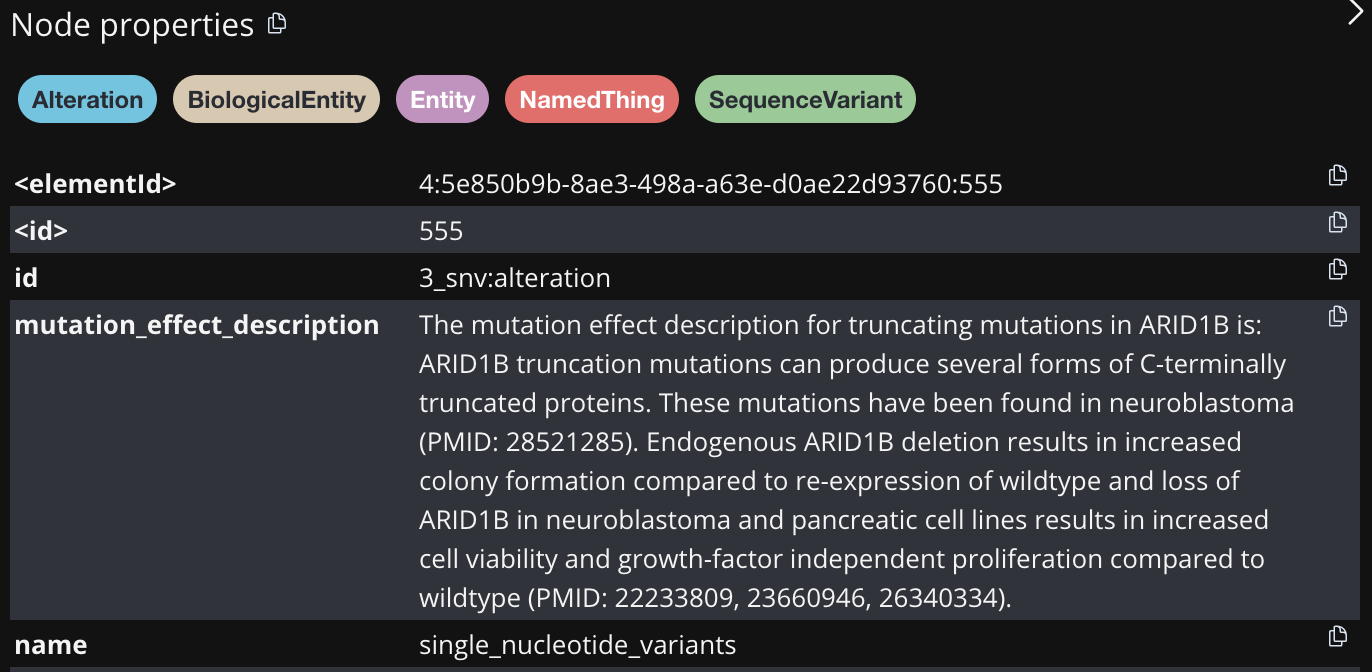

In [34]:
from IPython.display import display, JSON, Image

display(Image("figures/jobim/Node_properties_metadata.png"))

## 3. Multiple databases and additional transformers


Very often you might be in a situation where the information you wish to integrate is spread across several databases. In this case, you can use OntoWeaver to map multiple databases into a single graph. This is done by defining multiple mapping files, each corresponding to a different database, and then running the OntoWeaver CLI for all the adapters together.

In this example we will be using the same database as in the previous sections, containing SNVs, but we will expand our graph schema to include actionable drugs for the identified alterations. We will use the OncoKB database, which contains information about actionable drugs for alterations in cancer. We will also expand the SNV mapping file to include an additional node of type `functional outcome`. Below we show the updated graph schema, which includes the new nodes and edges.



In [37]:
display(SVG("figures/jobim/Example_3.svg"))

Below we show the mapping file for the OncoKB database.

In [38]:
# Read the file content.
with open("jobim/3_Multiple_databases/oncokb.yaml", "r") as file:
    content = yaml.safe_load(file)

# Display the content.
display(JSON(content))

<IPython.core.display.JSON object>

In this mapping file, we define the subject node as the `alteration` node, which is created from the `alteration` column, similarly as in the SNV example. We then define the `drug` node, which is created from the `treatment` column. Here we have our first example of a more complex transformer - `replace`, which replaces all the special characters (TODO MENTION SPECIAL CHARACTERS PRESENT IN THE DATA) with an underscore, defined via the `substitute` keyword, specific for the transformer, so that the node ID is valid. We then define the edge of type `alteration_biomarker_for_drug` between the `alteration` and `drug` nodes. We also include the `metadata` option, which adds a property called `name` to all the nodes and edges extracted from the OncoKB database, similarly as in the previous section.

We also expand the Single Nucleotide Variants mapping file with an additional transformer - `cat_format` to create an additional node of type `functional outcome`. Let's look at the mapping file for the SNV database.

In [39]:
# Read the file content.
with open("jobim/3_Multiple_databases/snv.yaml", "r") as file:
    content = yaml.safe_load(file)

# Display the content.
display(JSON(content))

<IPython.core.display.JSON object>

We see here the `cat_format` transformer, which concatenates the values of the `hugoSymbol` and `gene_role` columns. The concatenation of the value is done by using a `format_string`, defining how the extracted values of each columns will be treated. In this case the values will be concatenated with a `:` symbol inbetween. The new node will be of type `functional_outcome`, and the edge will be of type `alteration_causes_functional_outcome`.

These new nodes and edges need to be reflected in the BioCypher schema, so we need to update the schema file to include the new nodes and edges. Below we show the updated schema file.


In [40]:
# Read the file content.
with open("jobim/3_Multiple_databases/biocypher_schema.yaml", "r") as file:
    content = yaml.safe_load(file)

# Display the content.
display(JSON(content))

<IPython.core.display.JSON object>

We can now once again run the CLI to build up our graph database.

In [19]:
! poetry run ontoweave ./data/jobim_subsets/3_Multiple_databases/snv_subset_3.csv:./jobim/3_Multiple_databases/snv.yaml  ./data/jobim_subsets/3_Multiple_databases/treatments_subset.csv:./jobim/3_Multiple_databases/oncokb.yaml --biocypher-config ./jobim/3_Multiple_databases/biocypher_config.yaml --biocypher-schema ./jobim/3_Multiple_databases/biocypher_schema.yaml -a suffix

INFO -- This is BioCypher v0.12.2.
INFO -- Logging into `biocypher-log/biocypher-20260115-134508.log`.
/Users/mbaric/ontoweaver-vignette/biocypher-out/20260115134511/neo4j-admin-import-call.sh


Note that we have now modified the CLI to use two pairs of `DATABASE:MAPPING_FILE` mappings. This also needs to be reflected in case of using the API:

In [20]:
import biocypher
import ontoweaver

# Define the path to the mapping file. This time we define two paris of DATABASE:MAPPING_FILE mappings.
data_mappings = {f"./data/jobim_subsets/3_Multiple_databases/snv_subset_3.csv": f"./jobim/3_Multiple_databases/snv.yaml",
                 f"./data/jobim_subsets/3_Multiple_databases/treatments_subset.csv": f"./jobim/3_Multiple_databases/oncokb.yaml"}

# Extract nodes and edges from the mapping file.
nodes, edges = ontoweaver.extract(data_mappings, affix = "suffix")

# Transform nodes and edges to correct format.
nodes = ontoweaver.ow2bc(nodes)
edges = ontoweaver.ow2bc(edges)

# Write the nodes and edges using BioCypher.
bc = biocypher.BioCypher(
    biocypher_config_path=f"./jobim/3_Multiple_databases/biocypher_config.yaml",
    schema_config_path=f"./jobim/3_Multiple_databases/biocypher_schema.yaml",
)

bc.write_nodes(nodes)
bc.write_edges(edges)
bc.write_import_call()

INFO -- Running BioCypher with schema configuration from ./jobim/3_Multiple_databases/biocypher_schema.yaml.
INFO:biocypher:Running BioCypher with schema configuration from ./jobim/3_Multiple_databases/biocypher_schema.yaml.
INFO -- Loading ontologies...
INFO:biocypher:Loading ontologies...
INFO -- Instantiating OntologyAdapter class for https://github.com/biolink/biolink-model/raw/v3.2.1/biolink-model.owl.ttl.
INFO:biocypher:Instantiating OntologyAdapter class for https://github.com/biolink/biolink-model/raw/v3.2.1/biolink-model.owl.ttl.
INFO -- Instantiating OntologyAdapter class for http://purl.obolibrary.org/obo/so.owl.
INFO:biocypher:Instantiating OntologyAdapter class for http://purl.obolibrary.org/obo/so.owl.
INFO -- Instantiating OntologyAdapter class for http://purl.obolibrary.org/obo/so.owl.
INFO:biocypher:Instantiating OntologyAdapter class for http://purl.obolibrary.org/obo/so.owl.
INFO -- Creating output directory `/Users/mbaric/ontoweaver-vignette/biocypher-out/2026011513

'/Users/mbaric/ontoweaver-vignette/biocypher-out/20260115134528/neo4j-admin-import-call.sh'

We visualize below the generated graph.

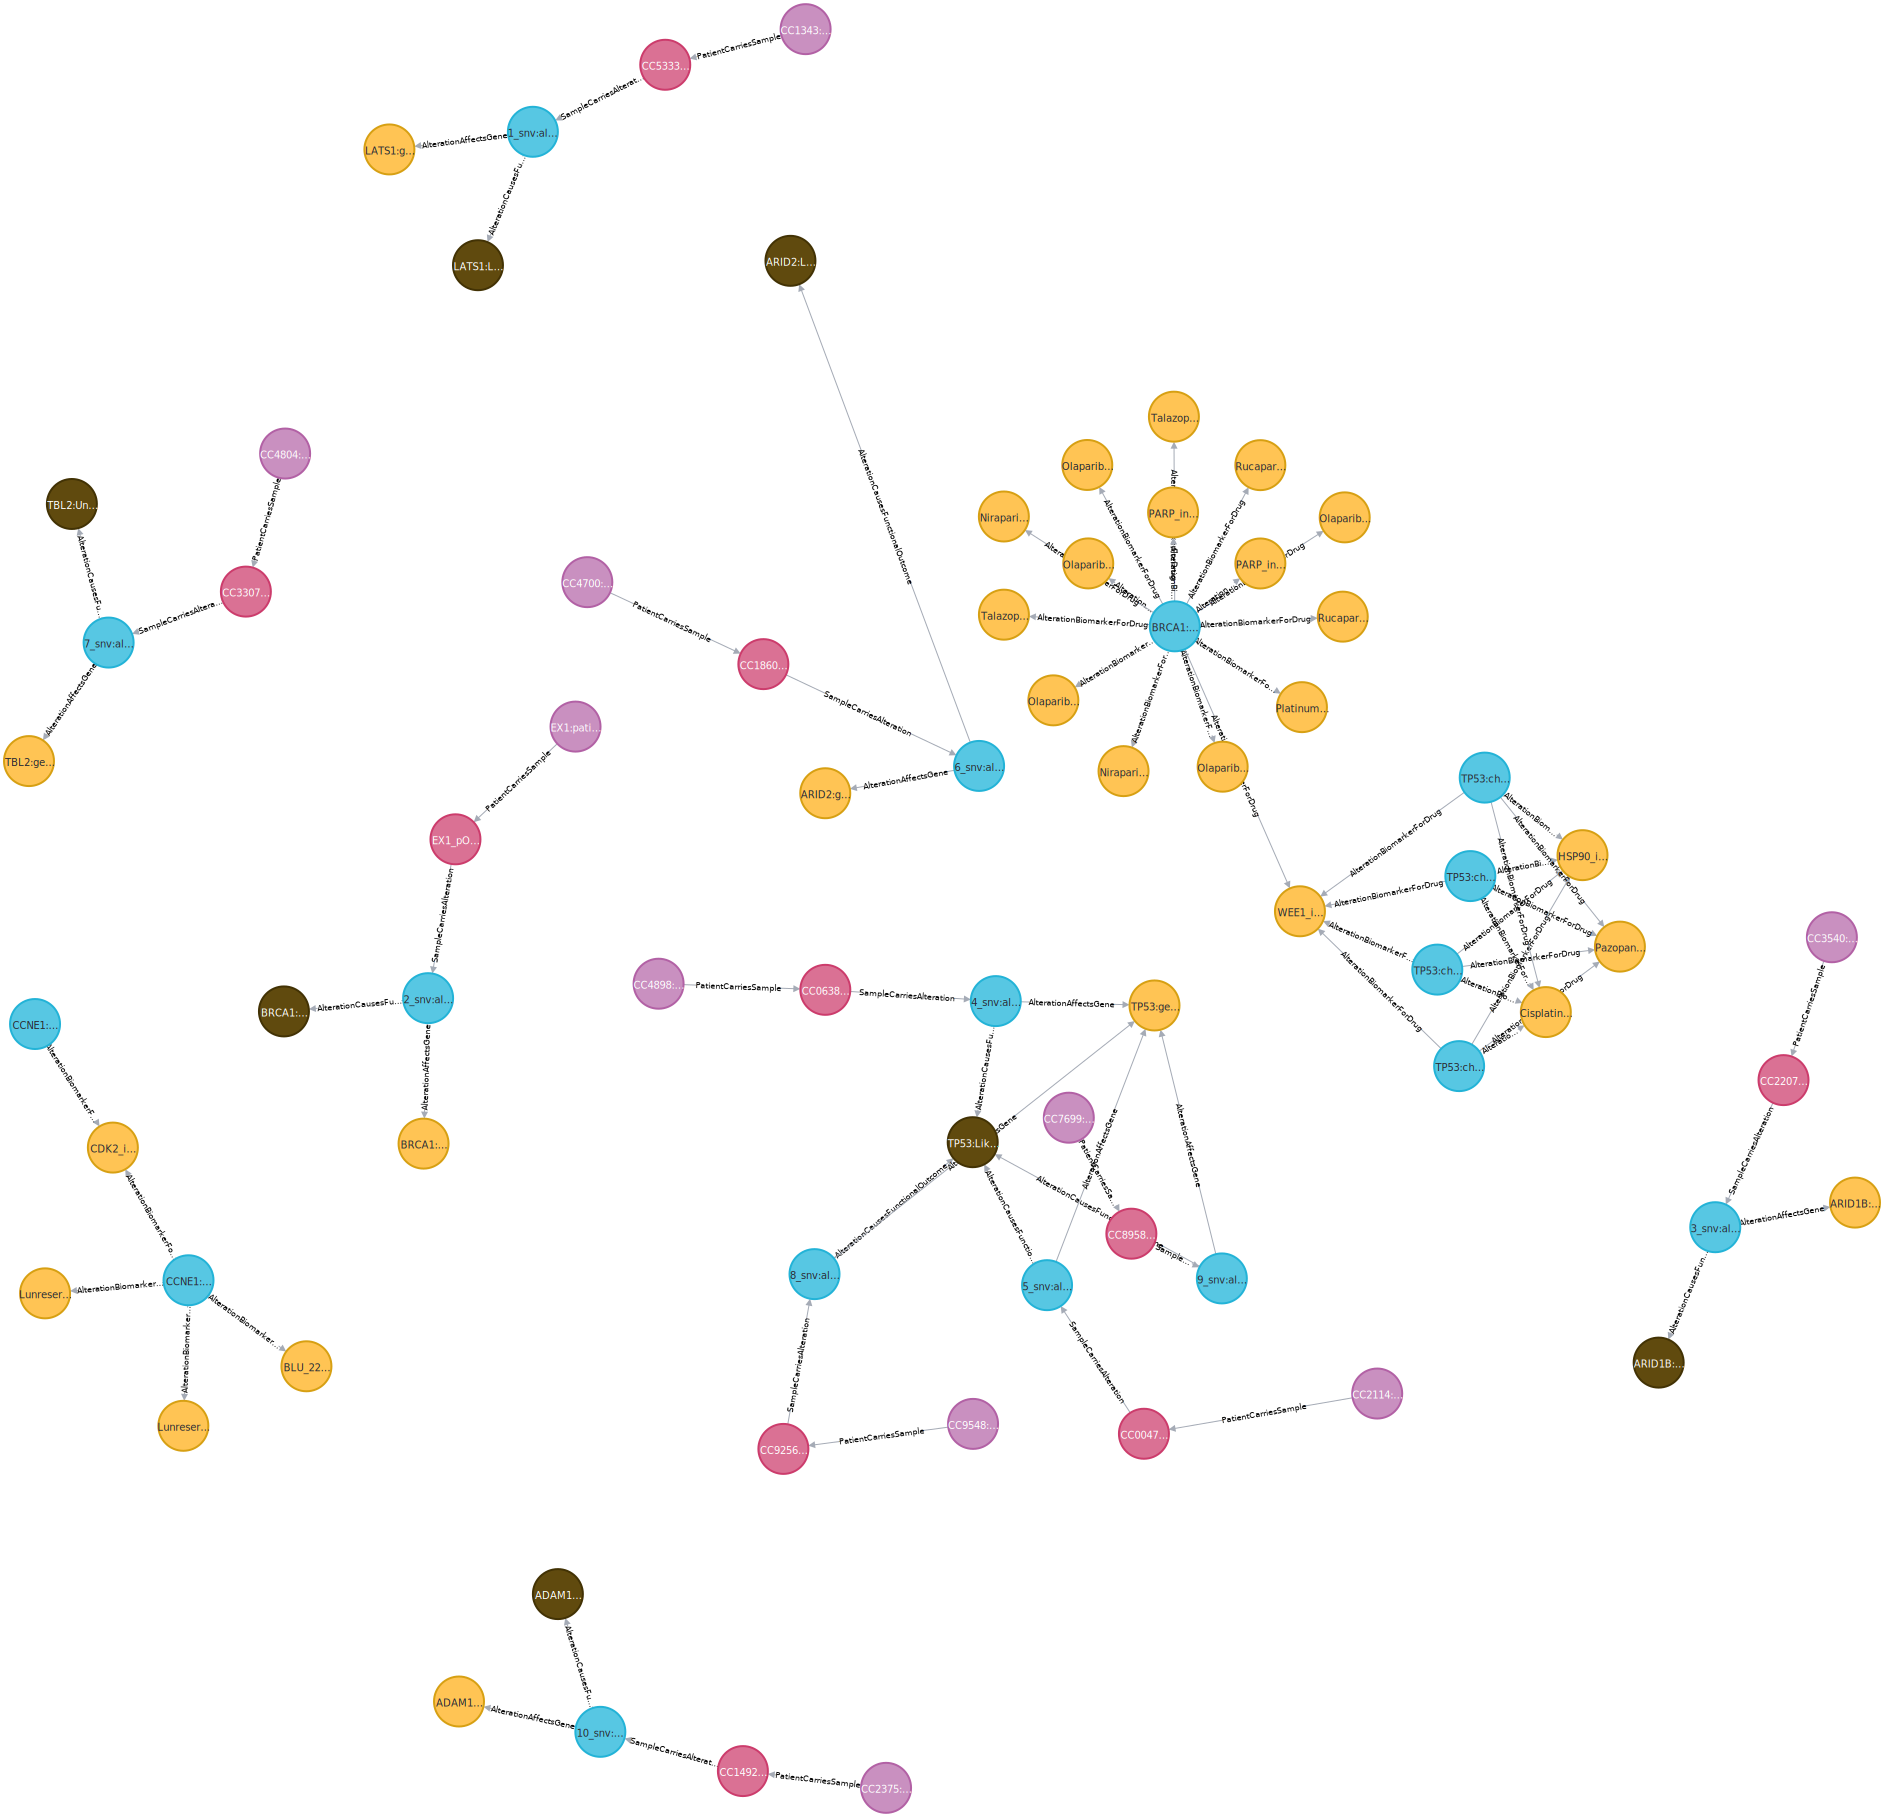

In [37]:
display(SVG("figures/jobim/graph_3.svg"))

## Fusion

When working with multiple databases to build SKGs, different resources can use differing terminology, or contain different information about the same entities. For example, gene names can often differ for the same genes based on the standard used.

For this purpose, OntoWeaver provides a *Fusion* core, which enables the reconciliation entities in the graph. In this example, we will showcase the Fusion core for the merging on properties of nodes from different databases. If you want to find details about the Fusion core, or a more complex use case, please refer to the [OntoWeaver documentation](https://ontoweaver.readthedocs.io/en/latest/readme_sections/information_fusion.html).

In this example we introduce the Copy Number Alterations (CNA) database, in addition to the SNV and OncoKB databases, shown in the previous sections.

Let's first have a look at the mapping file for the CNA database:

In [38]:
# Read the file content.
with open("jobim/4_Fusion/cna.yaml", "r") as file:
    content = yaml.safe_load(file)

# Display the content.
display(JSON(content))

<IPython.core.display.JSON object>

Similarly as in the case of the SNV mapping file, we define the subject node as the `patient` node, which is created from the `patient_id` column, and we define all of the other same types as in the previous cases - `alteration`, `gene`, and `sample`. Here we define two additional properties for the `alteration` node, which are `variant_summary`, and `tumor_type_summary`, and we include the newly defined properties in the BioCypher schema.

Here is the updated BioCypher schema file, which includes the new properties for the `alteration` node:

In [42]:
# Read the file content.
with open("jobim/4_Fusion/biocypher_schema.yaml", "r") as file:
    content = yaml.safe_load(file)

# Display the content.
display(JSON(content))

<IPython.core.display.JSON object>

Notice that, due to the different mapping files of the SNV and CNA databases, the `alteration` nodes in the two databases have different properties. The SNV database has a property called `mutationEffectDescription`, while the CNA database has properties called `variant_summary` and `tumor_type_summary`. In order to handle this, we can use the Fusion core to merge the properties of the `alteration` nodes from both databases.

An importatnt thing to to note is that the Biocypher schema must be updated to include all the possible properties for the `alteration` node, from both databases, in order to successfully run BioCypher. You can take a look at the schema file above.

Our updated graph schema, which includes the new properties for the `alteration` node, would thus look like this:

In [43]:
display(SVG("figures/jobim/Example_4.svg"))

Let's now run the `ontoweave` CLI:

In [21]:
! poetry run ontoweave ./data/jobim_subsets/4_Fusion/snv_subset_4.csv:./jobim/4_Fusion/snv.yaml  ./data/jobim_subsets/4_Fusion/treatments_subset.csv:./jobim/4_Fusion/oncokb.yaml data/jobim_subsets/4_Fusion/cna_subset.csv:./jobim/4_Fusion/cna.yaml --biocypher-config ./jobim/4_Fusion/biocypher_config.yaml --biocypher-schema ./jobim/4_Fusion/biocypher_schema.yaml -a suffix

INFO -- This is BioCypher v0.12.2.
INFO -- Logging into `biocypher-log/biocypher-20260115-134540.log`.
/Users/mbaric/ontoweaver-vignette/biocypher-out/20260115134544/neo4j-admin-import-call.sh


Apart from running the CLI, you may also run the Python API. Notice that it is a bit different compared to the previously seen one. This is due to the usage of the Fusion core, for property merging.

In [24]:
import biocypher
import ontoweaver

# Define the path to the mapping file. This time we define two paris of DATABASE:MAPPING_FILE mappings.
data_mappings = {f"./data/jobim_subsets/4_Fusion/snv_subset_4.csv": f"./jobim/4_Fusion/snv.yaml",
                 f"./data/jobim_subsets/4_Fusion/treatments_subset.csv": f"./jobim/4_Fusion/oncokb.yaml",
                 f"./data/jobim_subsets/4_Fusion/cna_subset.csv": f"./jobim/4_Fusion/cna.yaml"}

# Extract nodes and edges from the mapping file. Reconciliate properties, and write nodes.
ontoweaver.extract_reconciliate_write(data_to_mapping=data_mappings, affix = "suffix",
                                                     biocypher_config_path=f"./jobim/4_Fusion/biocypher_config.yaml",
                                                     schema_path=f"./jobim/4_Fusion/biocypher_schema.yaml",)

INFO -- Running BioCypher with schema configuration from ./jobim/4_Fusion/biocypher_schema.yaml.
INFO:biocypher:Running BioCypher with schema configuration from ./jobim/4_Fusion/biocypher_schema.yaml.
INFO -- Loading ontologies...
INFO:biocypher:Loading ontologies...
INFO -- Instantiating OntologyAdapter class for https://github.com/biolink/biolink-model/raw/v3.2.1/biolink-model.owl.ttl.
INFO:biocypher:Instantiating OntologyAdapter class for https://github.com/biolink/biolink-model/raw/v3.2.1/biolink-model.owl.ttl.
INFO -- Instantiating OntologyAdapter class for http://purl.obolibrary.org/obo/so.owl.
INFO:biocypher:Instantiating OntologyAdapter class for http://purl.obolibrary.org/obo/so.owl.
INFO -- Instantiating OntologyAdapter class for http://purl.obolibrary.org/obo/so.owl.
INFO:biocypher:Instantiating OntologyAdapter class for http://purl.obolibrary.org/obo/so.owl.
INFO -- Creating output directory `/Users/mbaric/ontoweaver-vignette/biocypher-out/20260115134622`.
INFO:biocypher:Cr

'/Users/mbaric/ontoweaver-vignette/biocypher-out/20260115134622/neo4j-admin-import-call.sh'

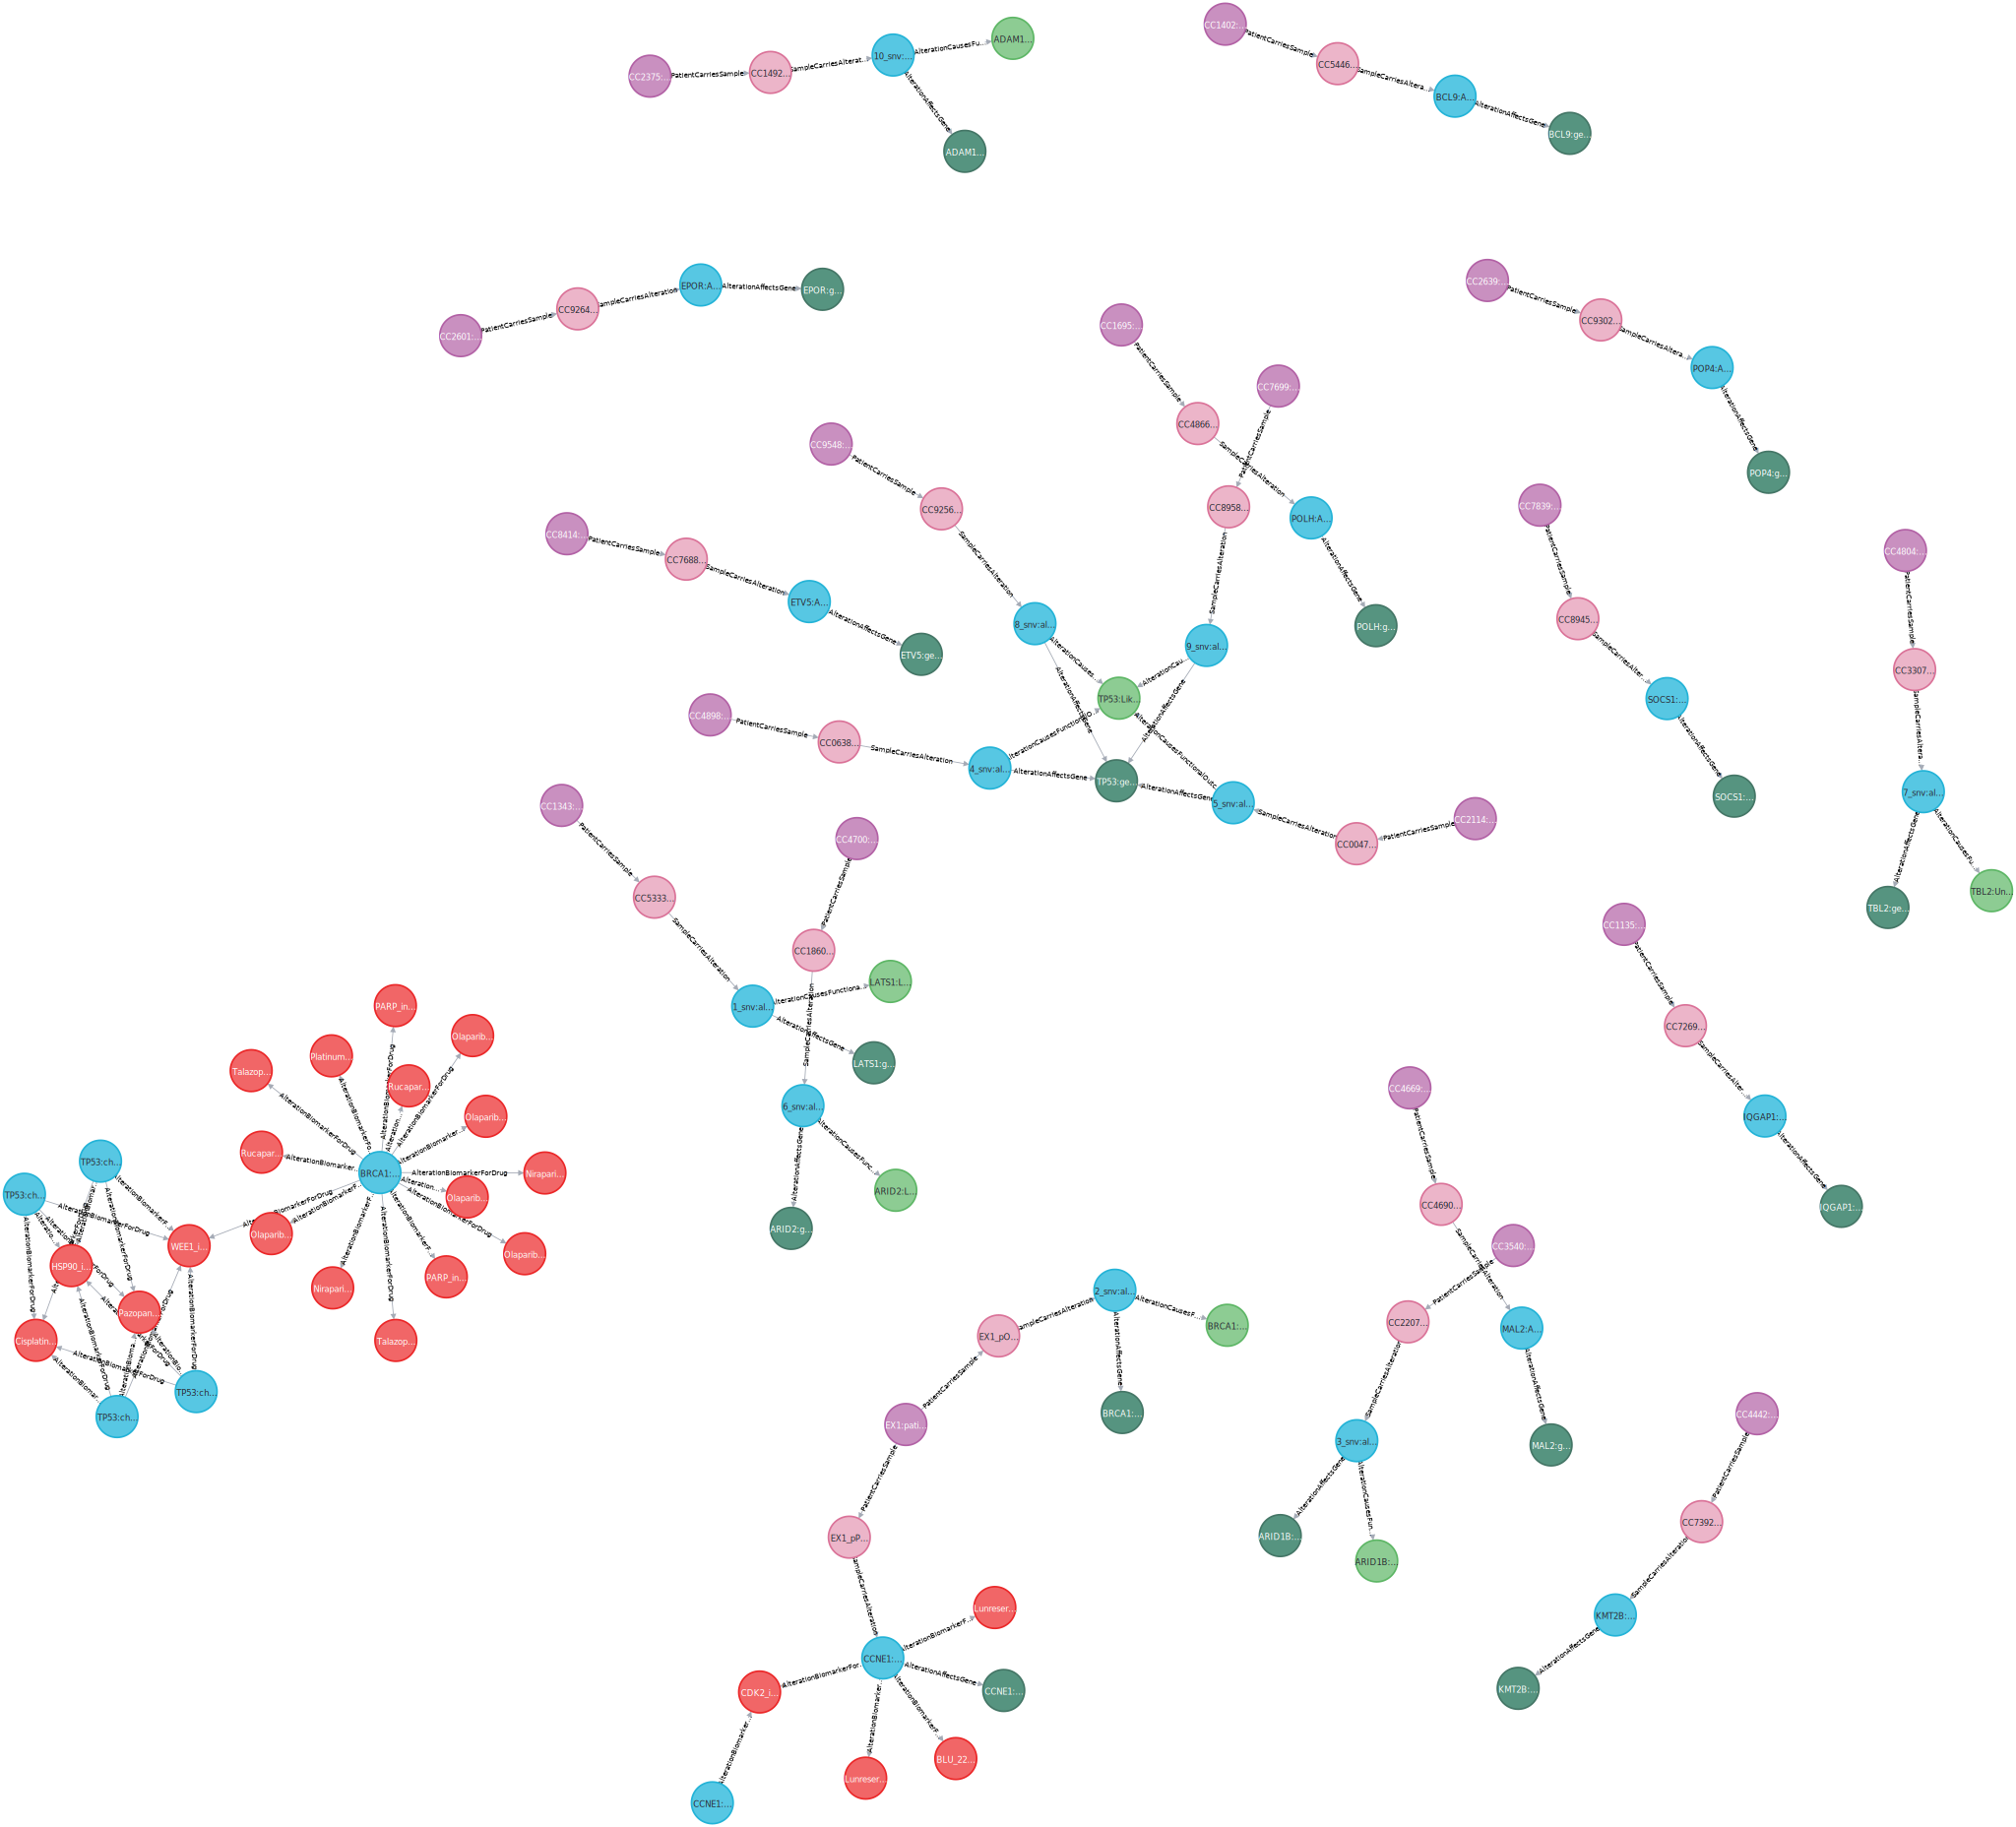

In [77]:
display(SVG("figures/jobim/graph_4.svg"))